In [1]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
# Before execute the code, add a shortcut of the folder 'Berkeley Capstone (Students)' to your drive
noteboook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code'
os.chdir(noteboook_path) 

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Load data

The data used below is extracted by the code in https://github.com/lcd-dal/feature-extraction-for-CERT-insider-threat-test-dataset

## By week

In [4]:
week_df = pd.read_csv('./ExtractedData/weekr4.2.csv')

In [ ]:
week_df.loc[:,'starttime'] = pd.to_datetime(week_df['starttime'])
week_df.loc[:,'endtime'] = pd.to_datetime(week_df['endtime'])
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## By day

In [ ]:
day_df = pd.read_csv('./ExtractedData/dayr4.2.csv')

In [ ]:
day_df.head()

,starttime,endtime,user,day,week,isweekday,isweekend,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,n_workhourlogon,workhourlogon_n-pc0,...,afterhourhttp_socnetf_n-pc1,afterhourhttp_socnetf_n-pc2,afterhourhttp_socnetf_n-pc3,afterhourhttp_n_cloudf,afterhourhttp_cloudf_mean_url_len,afterhourhttp_cloudf_mean_url_depth,afterhourhttp_cloudf_mean_http_c_len,afterhourhttp_cloudf_mean_http_c_nwords,afterhourhttp_cloudf_n-pc0,afterhourhttp_cloudf_n-pc1,afterhourhttp_cloudf_n-pc2,afterhourhttp_cloudf_n-pc3,afterhourhttp_n_jobf,afterhourhttp_jobf_mean_url_len,afterhourhttp_jobf_mean_url_depth,afterhourhttp_jobf_mean_http_c_len,afterhourhttp_jobf_mean_http_c_nwords,afterhourhttp_jobf_n-pc0,afterhourhttp_jobf_n-pc1,afterhourhttp_jobf_n-pc2,afterhourhttp_jobf_n-pc3,afterhourhttp_n_leakf,afterhourhttp_leakf_mean_url_len,afterhourhttp_leakf_mean_url_depth,afterhourhttp_leakf_mean_http_c_len,afterhourhttp_leakf_mean_http_c_nwords,afterhourhttp_leakf_n-pc0,afterhourhttp_leakf_n-pc1,afterhourhttp_leakf_n-pc2,afterhourhttp_leakf_n-pc3,afterhourhttp_n_hackf,afterhourhttp_hackf_mean_url_len,afterhourhttp_hackf_mean_url_depth,afterhourhttp_hackf_mean_http_c_len,afterhourhttp_hackf_mean_http_c_nwords,afterhourhttp_hackf_n-pc0,afterhourhttp_hackf_n-pc1,afterhourhttp_hackf_n-pc2,afterhourhttp_hackf_n-pc3,insider
0,1.262419e+09,1.262506e+09,10,5,0,0,1,39,0,4,15,29,0,43,43,44,41,25,34,34,0,0,0,32,32,0,0,0,2,2,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.262419e+09,1.262506e+09,12,5,0,0,1,39,0,4,15,23,0,42,41,34,20,27,35,35,0,0,0,35,35,0,0,0,0,0,0,0,0,2,2,0,0,0,2,2,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.262419e+09,1.262506e+09,59,5,0,0,1,39,0,4,15,29,0,25,19,44,22,30,34,34,0,0,0,32,32,0,0,0,2,2,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.262419e+09,1.262506e+09,95,5,0,0,1,39,0,4,15,11,0,37,36,15,41,19,36,36,0,0,0,36,36,0,0,0,0,0,0,0,0,2,2,0,0,0,2,2,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.262419e+09,1.262506e+09,123,5,0,0,1,39,0,4,15,11,0,15,42,36,22,32,34,34,0,0,0,34,34,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## By session

# Data Preprocessing

## Split Dataset

In [ ]:
def split_dataset(data):
    removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']
    x_cols = [i for i in data.columns if i not in removed_cols]
    
    data1stHalf = data[data.week <= max(data.week)/2]
    dataTest = data[data.week > max(data.week)/2]
    
    selectedTrainUsers =  set(data1stHalf[data1stHalf.insider > 0]['user'])
    nUsers = np.random.permutation(list(set(data1stHalf.user) - selectedTrainUsers))
    trainUsers = np.concatenate((list(selectedTrainUsers), nUsers[:200-len(selectedTrainUsers)]))

    unKnownTestUsers = list(set(dataTest.user) - selectedTrainUsers)
    
    xTrain = data1stHalf[data1stHalf.user.isin(trainUsers)][x_cols].values
    yTrain = data1stHalf[data1stHalf.user.isin(trainUsers)]['insider'].values
    yTrainBin = yTrain > 0
    # Wenqi: Test dataset not the validation dataset
    xTest = dataTest[dataTest.user.isin(unKnownTestUsers)][x_cols].values
    yTest = dataTest[dataTest.user.isin(unKnownTestUsers)]['insider'].values
    yTestBin = yTest > 0

    X = data[x_cols].values
    y = data['insider'].values
    yBin = y > 0
    
    return X, yBin, xTrain, yTrainBin, xTest, yTestBin, x_cols

In [ ]:
X, yBin, xTrain, yTrainBin, xTest, yTestBin, feature_names = split_dataset(week_df)

## Temporal Information
- Exploiting the fact that insiders are essentially regular employees before they start performing malicious actions, data representation approaches using temporal information highlights the trends/changes in the user behavior over time. 
- The approach performs **concatenating or comparing** a data point to a time window of the most recent data of the same user.

In [ ]:
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from scipy import stats 

In [ ]:
window = 4
method = 'Percentile' #['Percentile', 'Mean Difference', 'Median Difference']

removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']
x_cols = [i for i in week_df.columns if i not in removed_cols]

output = pd.DataFrame(columns=['week', 'user','insider']+x_cols)
for t in trange(window+1, week_df.week.max()+1):
  X = week_df[week_df.week.isin([w for w in range(t-window, t)])]
  x_t = week_df[week_df.week==t]
  user_list = set(X.user.tolist()).intersection(set(x_t.user.tolist()))

  for user in user_list:
    X_u = X[X.user == user]
    xt_u = x_t[x_t.user == user]
    xt_output = [t, user, xt_u.insider.values[0]]

    if method == 'Percentile':
      for feature in x_cols:
        pct = stats.percentileofscore(X_u[feature].values, xt_u[feature].values)
        xt_output.append(pct)
    else:
      xt_u_list = xt_u.reset_index().loc[0, x_cols].tolist()
      if method == 'Median Difference':
        X_u_list = X_u.groupby("user").median().reset_index().loc[0, x_cols].tolist()
        diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
      elif method == 'Mean Difference':
        X_u_list = X_u.groupby("user").mean().reset_index().loc[0, x_cols].tolist()
        diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
      xt_output = xt_output + diff

    output = output.append(dict(zip(output.columns,xt_output)), ignore_index=True)

output.to_csv("percentile_W30", index=False)

100%|██████████| 68/68 [2:31:08<00:00, 133.35s/it]


In [ ]:
percentile_W30 = pd.read_csv("percentile_W30")
percentile_W30.head()

,week,user,insider,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,n_workhourlogon,...,weekendhttp_socnetf_n-pc0,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3
0,5.0,0.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,100.0,...,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5
1,5.0,1.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,50.0,50.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,50.0,50.0,62.5,62.5,62.5,62.5,...,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5
2,5.0,2.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,25.0,25.0,62.5,62.5,62.5,25.0,25.0,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,100.0,...,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5
3,5.0,3.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,...,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5
4,5.0,4.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,87.5,87.5,62.5,62.5,62.5,100.0,100.0,62.5,62.5,62.5,0.0,0.0,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,...,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5,62.5


In [ ]:
X, yBin, xTrain, yTrainBin, xTest, yTestBin, feature_names = split_dataset(percentile_W30)

## Define metrics

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
def acu_curve(y,prob):
    fpr, tpr, threshold = roc_curve(y,prob)
    roc_auc = auc(fpr,tpr)
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()

# Classification model

## Random tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, classification_report, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV, TimeSeriesSplit

In [ ]:
run = 1
np.random.seed(run)

In [ ]:
def plot_feature_importance(feature_names, importances, std):
  forest_importances = pd.DataFrame({"feature": pd.Series(feature_names), "importances": pd.Series(importances)})
  forest_importances.sort_values(by = "importances", ascending=False, inplace=True)
  forest_importances.reset_index(drop=True)

  plt.figure(figsize= (15, 6))
  # plt.hist(forest_importances.loc[:50, "importances"], bins=50)
  plt.hist(forest_importances["importances"], bins=50)
  plt.xlabel('Feature Importances') 
  plt.ylabel('Counr') 
  plt.title(r'Histogram of Feature Importances') 
  plt.show()

  top = 30
  tmp = forest_importances[:top]
  plt.figure(figsize= (15, 6))
  plt.bar(tmp["feature"], tmp["importances"], yerr=std[:top])
  plt.xticks(rotation=90, fontsize=10)
  plt.ylabel("Mean decrease in impurity")
  plt.title("First {} Feature importances using MDI".format(top))
  plt.show()

  # forest_importances["importances"].quantile(0.9)

###By week

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(xTrain, yTrainBin)

y_pred = rf.predict(xTest)
print(classification_report(yTestBin, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     31772
        True       0.78      0.34      0.47       167

    accuracy                           1.00     31939
   macro avg       0.89      0.67      0.73     31939
weighted avg       1.00      1.00      1.00     31939



Train the logistic regreesion model and find the best hyperparamter via Random Search

<Figure size 432x288 with 0 Axes>

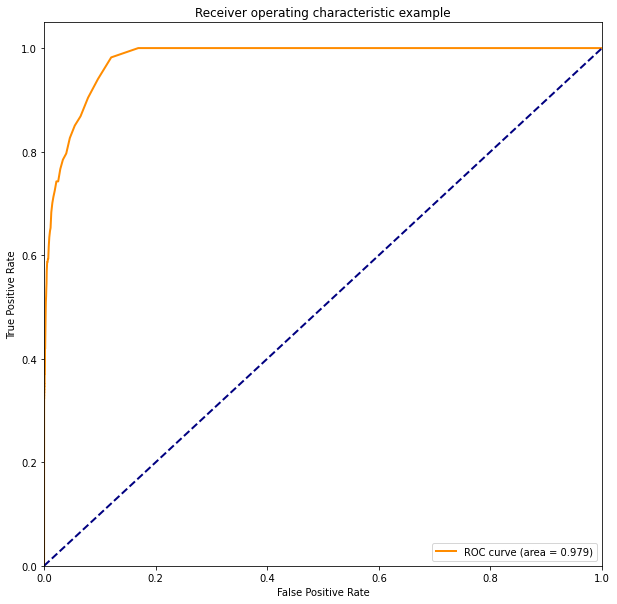

In [ ]:
y_score = rf.predict_proba(xTest)
acu_curve(yTestBin, pd.DataFrame(y_score)[1])

 #### Random Search

In [ ]:
xTrain.shape

(14026, 663)

In [ ]:
# X_rf = np.concatenate((xTrain, xTest), axis=0)
# y_rf = np.concatenate((yTrainBin, yTestBin), axis=0)
# test_fold = -np.ones(X_rf.shape[0]) 
# test_fold[-len(yTestBin):] = 0
tscv = TimeSeriesSplit()

RS_rf = RandomForestClassifier()

distributions = dict(n_estimators=[100,200,500],max_depth=[6,8,10]) 

n_iter = 5
RS = RandomizedSearchCV(
    RS_rf, 
    distributions, 
    n_iter=n_iter,
    refit="f1_macro",
    cv=tscv, 
    # scoring=["f1_macro", "f1_micro","roc_auc", "precision", "recall"],
    scoring=["f1_macro", "f1_micro", "precision", "recall"],
    random_state=0)

RS.fit(xTrain, yTrainBin)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being se

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [6, 8, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=0, refit='f1_macro',
                   scoring=['f1_macro', 'f1_micro', 'precision', 'recall'])

In [ ]:
best_models_LR = RS.cv_results_
RS.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [ ]:
y_pred = RS.predict(xTest)
print(classification_report(yTestBin, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     31772
        True       0.78      0.32      0.45       167

    accuracy                           1.00     31939
   macro avg       0.89      0.66      0.72     31939
weighted avg       1.00      1.00      1.00     31939



<Figure size 432x288 with 0 Axes>

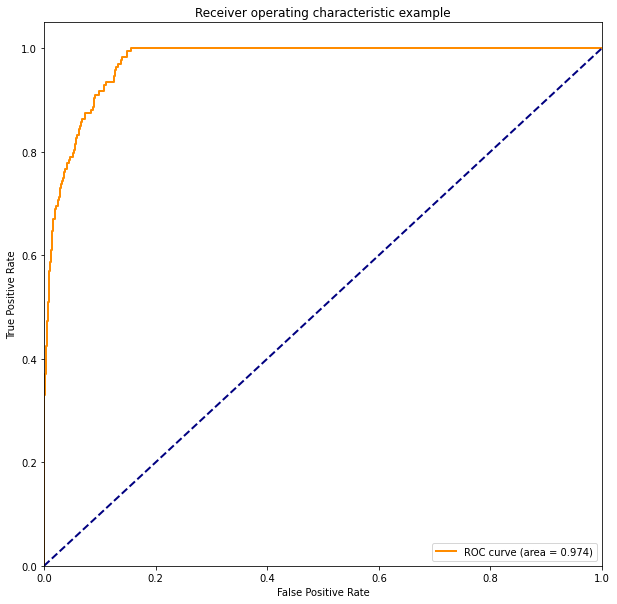

In [ ]:
y_score = RS.predict_proba(xTest)
acu_curve(yTestBin, pd.DataFrame(y_score)[1])

#### Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

rf = RS.best_estimator_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
impurity_importances = rf.feature_importances_
# feature_importances = permutation_importance(
#     rf, xTest, yTestBin, n_repeats=2, random_state=42, n_jobs=2
# ).importances_mean

plot_feature_importance(feature_names, impurity_importances, std)
# plot_feature_importance(feature_names, feature_importances, std)


###By day

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(xTrain, yTrainBin)

print(classification_report(yTestBin, rf.predict(xTest)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     31772
        True       0.76      0.33      0.46       167

    accuracy                           1.00     31939
   macro avg       0.88      0.66      0.73     31939
weighted avg       1.00      1.00      1.00     31939



<Figure size 432x288 with 0 Axes>

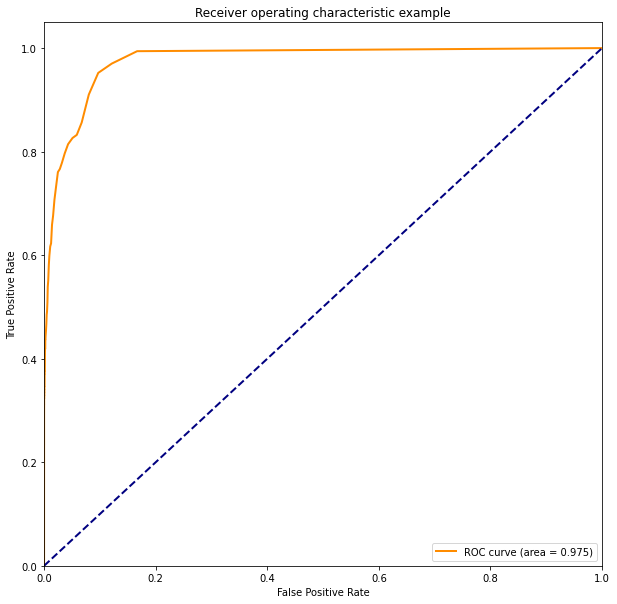

In [ ]:
y_score = rf.predict_proba(xTest)
acu_curve(yTestBin, pd.DataFrame(y_score)[1])

## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# X_rf = np.concatenate((xTrain, xTest), axis=0)
# y_rf = np.concatenate((yTrainBin, yTestBin), axis=0)
# test_fold = -np.ones(X_rf.shape[0]) 
# test_fold[-len(yTestBin):] = 0
tscv = TimeSeriesSplit()

model_xgb = xgb.XGBClassifier(booster='gbtree', scale_pos_weight=15, eval_metric='auc')

params_max_depth = [4, 6, 8, 10]
params_n_estimators = [100, 200, 300, 400, 500]
params_colsample_bytree = [0.3, 0.5, 0.7, 0.9]
params_subsample = [0.3, 0.5, 0.7, 0.9]
param_grid_xgb = {'max_depth' : params_max_depth,
                  'n_estimators' : params_n_estimators,
                  'colsample_bytree' : params_colsample_bytree,
                  'subsample' : params_subsample}
n_iter = 5
RS = RandomizedSearchCV(
    model_xgb, 
    param_grid_xgb, 
    n_iter=n_iter,
    refit="f1_macro",
    cv=tscv, 
    scoring=["f1_macro", "f1_micro","roc_auc", "precision", "recall"],
    random_state=0)

RS.fit(xTrain, yTrainBin)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    result = getattr(estimator, method)(*args, **kwargs)
AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/us

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(eval_metric='auc',
                                           scale_pos_weight=15),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7,
                                                             0.9],
                                        'max_depth': [4, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.3, 0.5, 0.7, 0.9]},
                   random_state=0, refit='f1_macro',
                   scoring=['f1_macro', 'f1_micro', 'roc_auc', 'precision',
                            'recall'])

In [ ]:
best_models_XGB = RS.cv_results_
RS.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 6,
 'n_estimators': 100,
 'subsample': 0.5}

In [ ]:
print(classification_report(yTestBin, RS.predict(xTest)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     31772
        True       0.54      0.44      0.48       167

    accuracy                           1.00     31939
   macro avg       0.77      0.72      0.74     31939
weighted avg       0.99      1.00      0.99     31939



<Figure size 432x288 with 0 Axes>

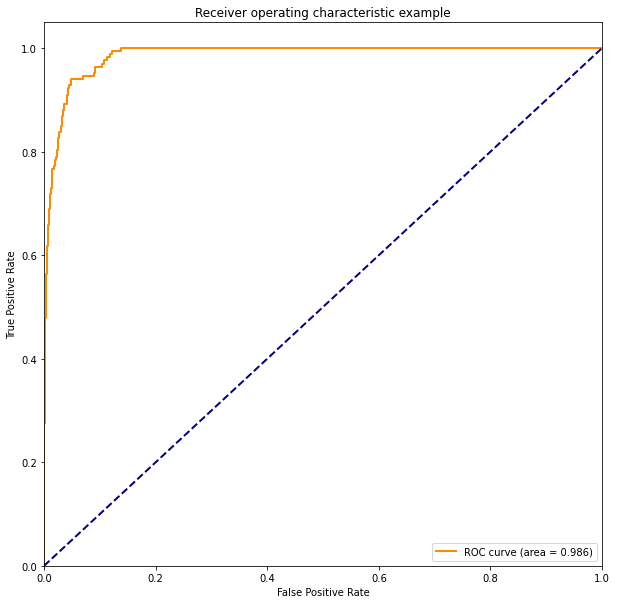

In [ ]:
y_score = RS.predict_proba(xTest)
acu_curve(yTestBin, pd.DataFrame(y_score)[1])

# Unsupervised Model

## Autoencoder

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import paired_distances
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
# xTest = scaler.transform(xTest)
X = scaler.transform(X)

l = len(feature_names)
ae = MLPRegressor(hidden_layer_sizes=(int(l/4), int(l/8), 
                                      int(l/4)), max_iter=25, random_state=10)
# change activation fuction -- Logistic tanh

ae.fit(xTrain, xTrain)
reconstructionError = paired_distances(X, ae.predict(X))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


<Figure size 432x288 with 0 Axes>

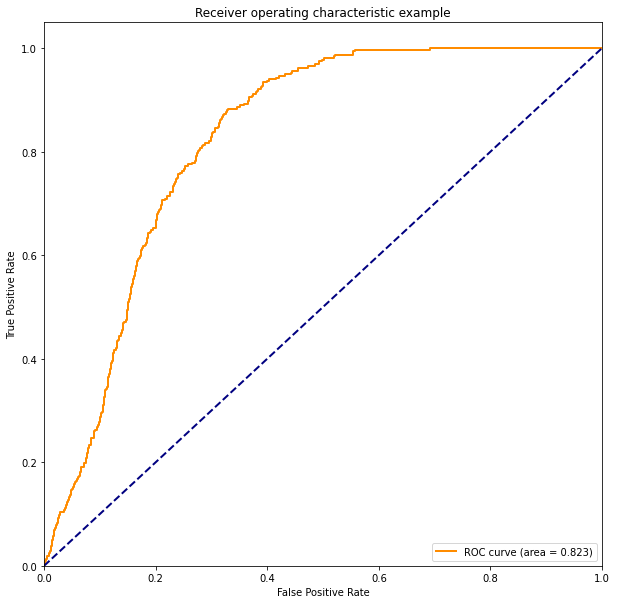

In [ ]:
acu_curve(yBin, reconstructionError)

In [ ]:
print('Detection rate at different budgets:')
for ib in [0.001, 0.01, 0.05, 0.1, 0.2]:
    threshold = np.percentile(reconstructionError, 100-100*ib)
    flagged = np.where(reconstructionError>threshold)[0]
    dr = sum(yBin[flagged]>0)/sum(yBin>0)
    print(f'{100*ib}%, DR = {100*dr:.2f}%')

Detection rate at different budgets:
0.1%, DR = 0.32%
1.0%, DR = 2.53%
5.0%, DR = 14.56%
10.0%, DR = 27.53%
20.0%, DR = 65.19%


## Isolation Forest
[Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) Algorithm returns the anomaly score of each sample using the IsolationForest algorithm
- The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest. 
- The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.


In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
IF = IsolationForest(n_estimators=200, max_samples=256)
IF.fit(xTest)
IF_score = IF.decision_function(xTest)

In [ ]:
print('Detection rate at different budgets:')
for ib in [0.001, 0.01, 0.05, 0.1, 0.2]:
    threshold = np.percentile(IF_score, 100*ib)
    flagged = np.where(IF_score<threshold)[0]
    dr = sum(yTestBin[flagged]>0)/sum(yTestBin>0)
    print(f'{100*ib}%, DR = {100*dr:.2f}%')

Detection rate at different budgets:
0.1%, DR = 0.00%
1.0%, DR = 1.80%
5.0%, DR = 6.59%
10.0%, DR = 22.16%
20.0%, DR = 73.05%


## Local Outlier Factor (LOF)
[Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) measures the local deviation of the density of a given sample with respect to its neighbors.
- locality is given by k-nearest neighbors, whose distance is used to estimate the local density. 
- By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
LOF = LocalOutlierFactor(n_neighbors=20, metric='euclidean', algorithm='auto')
LOF.fit_predict(xTest)
LOF_score = LOF.negative_outlier_factor_

In [ ]:
print('Detection rate at different budgets:')
for ib in [0.001, 0.01, 0.05, 0.1, 0.2]:
    threshold = np.percentile(LOF_score, 100*ib)
    flagged = np.where(LOF_score<threshold)[0]
    dr = sum(yTestBin[flagged]>0)/sum(yTestBin>0)
    print(f'{100*ib}%, DR = {100*dr:.2f}%')

Detection rate at different budgets:
0.1%, DR = 5.99%
1.0%, DR = 7.19%
5.0%, DR = 18.56%
10.0%, DR = 23.95%
20.0%, DR = 43.11%
